In [1]:
###########IMPORTS############

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import functional_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import tensor_array_ops

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
###########INTEGRATOR FRAMEWORK############

#1 Constraint Checks

def _check_input_types(t, y0): # Ensure input is Correct
    if not (y0.dtype.is_floating or y0.dtype.is_complex):
        raise TypeError('`y0` must have a floating point or complex floating point dtype')
    if not t.dtype.is_floating:
        raise TypeError('`t` must have a floating point dtype')
        
def _assert_increasing(t): # Check Time is Monotonous
    assert_increasing = control_flow_ops.Assert(math_ops.reduce_all(t[1:] > t[:-1]), ['`t` must be monotonic increasing'])
    return ops.control_dependencies([assert_increasing])

#2 Integrator Class

class _Integrator():
    
    def integrate(self, evol_func, y0, time_grid): # iterator
        time_delta_grid = time_grid[1:] - time_grid[:-1]
        scan_func = self._make_scan_func(evol_func)
        y_grid = functional_ops.scan(scan_func, (time_grid[:-1], time_delta_grid),y0)
        return array_ops.concat([[y0], y_grid], axis=0)
    
    def _make_scan_func(self, evol_func): # stepper function
        
        def scan_func(y, t_dt): 
            if n_>0:
                t,dt = t_dt
                
                dy = self._step_func(evol_func, t, dt, y)
                dy = math_ops.cast(dy, dtype=y.dtype)
                out = y + dy
                
                ## Operate on non-integral
                
                ft = y[-n_:]
                
                l = tf.zeros(tf.shape(ft),dtype=ft.dtype)
                l_ = t-ft
                
                z = tf.less(y[:n_],F_b)
                z_ = tf.greater_equal(out[:n_],F_b)
                
                df = tf.where(tf.logical_and(z,z_),l_,l)
                
                ft_ = ft+df
                
                return tf.concat([out[:-n_],ft_],0)

            else:
                t, dt = t_dt
                dy = self._step_func(evol_func, t, dt, y)
                dy = math_ops.cast(dy, dtype=y.dtype)
                return y + dy
        
        return scan_func

    def _step_func(self, evol_func, t, dt, y):
        k1 = evol_func(y, t)
        half_step = t + dt / 2
        dt_cast = math_ops.cast(dt, y.dtype)

        k2 = evol_func(y + dt_cast * k1 / 2, half_step)
        k3 = evol_func(y + dt_cast * k2 / 2, half_step)
        k4 = evol_func(y + dt_cast * k3, t + dt)
        return math_ops.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)

#3 Integral Caller

def odeint_fixed(func, y0, t):
    t = ops.convert_to_tensor(t, preferred_dtype=dtypes.float64, name='t')
    y0 = ops.convert_to_tensor(y0, name='y0')
    _check_input_types(t, y0)

    with _assert_increasing(t):
        return _Integrator().integrate(func, y0, t)

In [18]:
n_n = 3 # number of neurons
t = np.arange(0.0, 500, 0.01)# duration of simulation

C_m  =   [1.0]*n_n # n_n x 1 vector for capacitance
g_Na = [120.0]*n_n # n_n x 1 vector for sodium conductance
g_K  =  [36.0]*n_n # n_n x 1 vector for potassium conductance
g_L  =   [0.3]*n_n # n_n x 1 vector for leak conductance
E_Na =  [50.0]*n_n # n_n x 1 vector for Na Potential
E_K  = [-77.0]*n_n # n_n x 1 vector for K Potential
E_L  = [-54.387]*n_n # n_n x 1 vector for Leak Potential
F_b = [0.0]*n_n # n_n x 1 vector for fire potential

inp = [-2.5,-5.0,-10.0]#np.random.choice([0,6],n_n)

# ACETYLCHOLINE

ach_mat = np.array([[0.0,0.0,0.0],
                    [0.0,0.0,0.0],
                    [0.0,0.0,0.0]])

"""ach_mat = np.array([[0.0,0.0],
                    [1.0,0.0]])"""

"""ach_mat = np.random.choice([0.0,1.0],(n_n,n_n),p=[0.9,0.1])
np.fill_diagonal(ach_mat,0)"""

#alp = [10.0]*(n_n**2)
#bet = [0.16]*(n_n**2)

n_syn_ach = int(np.sum(ach_mat))
alp_ach = [10.0]*n_syn_ach
bet_ach = [0.2]*n_syn_ach
t_max = 0.3 
t_delay = 0
A = [0.5]*n_n
g_ach = [0.3]*n_n
E_ach = [0.0]*n_n

# FAST GABA

fgaba_mat = np.array([[0.0,0.0,0.0],
                      [0.0,0.0,0.0],
                      [0.0,0.0,0.0]])

"""fgaba_mat = np.array([[0.0,1.0],
                    [0.0,0.0]])"""

"""fgaba_mat = np.random.choice([0.0,1.0],(n_n,n_n),p=[0.999,0.001])
np.fill_diagonal(fgaba_mat,0)"""


n_syn_fgaba = int(np.sum(fgaba_mat))
alp_fgaba = [10.0]*n_syn_fgaba
bet_fgaba = [0.16]*n_syn_fgaba
V0 = [-20.0]*n_n
sigma = [1.5]*n_n
g_fgaba = [0.8]*n_n
E_fgaba = [-70.0]*n_n

def alpha_m(V):
    return 0.1*(V+40.0)/(1.0 - tf.exp(-(V+40.0) / 10.0))
def beta_m(V):
    return 4.0*tf.exp(-(V+65.0) / 18.0)
def alpha_h(V):
    return 0.07*tf.exp(-(V+65.0) / 20.0)
def beta_h(V):
    return 1.0/(1.0 + tf.exp(-(V+35.0) / 10.0))
def alpha_n(V):
    return 0.01*(V+55.0)/(1.0 - tf.exp(-(V+55.0) / 10.0))
def beta_n(V):
    return 0.125*tf.exp(-(V+65) / 80.0)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)
def I_L(V):
    return g_L * (V - E_L)

#def I_ach(o,V):
#    o_ = tf.reshape(o,(n_n,n_n))
#    return tf.reduce_sum(g_ach*o_*(V-E_ach),1)

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.reshape(o_,(n_n,n_n))
    return tf.reduce_sum(g_ach*o_*(V-E_ach),1)

def I_fgaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),fgaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.reshape(o_,(n_n,n_n))
    return tf.reduce_sum(g_fgaba*o_*(V-E_fgaba),1)


def I_inj_t(t):
    #return 10*tf.sin(t/Inj_peak)
    return tf.where(tf.logical_and(tf.greater(t,100),tf.less(t,400)),tf.constant(inp,dtype=tf.float64),tf.constant([0]*n_n,dtype=tf.float64))

In [19]:
def dAdt(X, t):
   
    V = X[0:n_n]
    m = X[n_n:2*n_n]
    h = X[2*n_n:3*n_n]
    n = X[3*n_n:4*n_n]
    #o = X[4*n_n:4*n_n+(n_n**2)]
    o_ach = X[4*n_n:4*n_n+n_syn_ach]
    o_fgaba = X[4*n_n+n_syn_ach:4*n_n+n_syn_ach+n_syn_fgaba]
    fire_t = X[-n_n:]
    
    dVdt = (I_inj_t(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V) - I_ach(o_ach,V) - I_fgaba(o_fgaba,V)) / C_m
    dmdt = alpha_m(V)*(1.0-m) - beta_m(V)*m
    dhdt = alpha_h(V)*(1.0-h) - beta_h(V)*h
    dndt = alpha_n(V)*(1.0-n) - beta_n(V)*n
    
    A_ = tf.constant(A,dtype=tf.float64)
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,tf.zeros(tf.shape(A_),dtype=A_.dtype))
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    T_fgaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_fgaba = tf.multiply(tf.constant(fgaba_mat,dtype=tf.float64),T_fgaba)
    T_fgaba = tf.boolean_mask(tf.reshape(T_fgaba,(-1,)),fgaba_mat.reshape(-1) == 1)
    do_fgabadt = alp_fgaba*(1.0-o_fgaba)*T_fgaba - bet_fgaba*o_fgaba
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype)

    out = tf.concat([dVdt,dmdt,dhdt,dndt,do_achdt,do_fgabadt,dfdt],0)
    return out

In [20]:
global n_
n_ = n_n
state_vector = [-65]*n_n + [0.05]*n_n + [0.6]*n_n + [0.32]*n_n + [0]*(n_syn_ach) + [0]*(n_syn_fgaba) +[-500]*n_n
init_state = tf.constant(state_vector, dtype=tf.float64)
tensor_state = odeint_fixed(dAdt, init_state, t)

In [21]:
%%time
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state = sess.run(tensor_state)

CPU times: user 4min 4s, sys: 1min 23s, total: 5min 28s
Wall time: 1min 16s


<IPython.core.display.Javascript object>


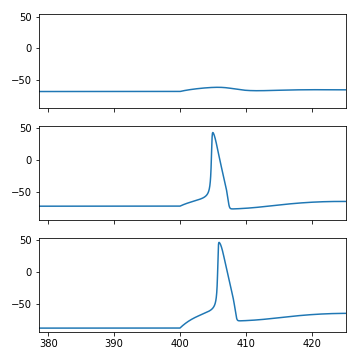

In [23]:
%matplotlib nbagg
fig, ax = plt.subplots(3, 1,figsize=(5,5),sharex=True,sharey=True)
for n,i in enumerate(ax):
    i.plot(t,state[:,n])
plt.tight_layout()
plt.show()